## Functions

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore,ttest_ind,ttest_rel,pearsonr,spearmanr

sns.set(font_scale=1.5,style="white")
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

In [2]:
bold_path = '/data/dy/TIS_MDD/BOLD'
sub_ls = os.listdir(bold_path)

RSS_dynamic_path = '/data/dy/TIS_MDD/HAC/RSS_dynamic'
Event_mask_path = '/data/dy/TIS_MDD/HAC/Event_mask'
Top_bold_path = '/data/dy/TIS_MDD/HAC/Top_bold'
Top_fc_path = '/data/dy/TIS_MDD/HAC/Top_fc'

In [3]:
demo_info = pd.read_csv('/data/dy/TIS_MDD/demo_info.csv',index_col=0)
demo_info['sub_id'] = demo_info.index
demo_info['sex_id'] = [1 if i=='M' else 0 for i in demo_info['sex']]

def fun_add_demo_time(data,run_label):
    data = pd.concat([data,demo_info],axis=1)
    data['time'] = [run_label for i in range(data.shape[0])]
    data = data.dropna(axis=0)
    return data

def fun_concat(data1,data2):
    df = pd.concat([data1,data2],axis=1)
    df = df.dropna(axis=0)
    cut_ = int(df.shape[1]/2)
    data = pd.concat([df.iloc[:,:cut_],df.iloc[:,cut_:]])
    return data

In [4]:
def read_bold(sub,run_label):
    bold_ctx = pd.read_csv(os.path.join(bold_path,sub,run_label,schaefer+'.csv'))
    bold_sub = pd.read_csv(os.path.join(bold_path,sub,run_label,'hcp.csv'))
    bold = pd.concat([bold_ctx,bold_sub],axis=1)
    return bold

In [5]:
def fun_match_scale(scale,timepoint):
    result = pd.DataFrame([])
    df = scale.copy()
    process = df[df['condition'] == timepoint]
    for sub in sub_ls:
        if(sub in process.index):
            result = pd.concat([result,process.loc[sub,:]],axis=1)
    return result.T

def fun_scale_change(scale,col_name,after_label):
    df = pd.concat([fun_match_scale(scale,'pre')[col_name],fun_match_scale(scale,after_label)[col_name]],axis=1).dropna(axis=0)
    df.columns = ['baseline','!baseline']
    df = pd.DataFrame(df['!baseline']-df['baseline'],columns=['scale'])
    return df

madrs = pd.read_csv('/data/dy/TIS_MDD/Scales/madrs.csv',index_col='sub') ## MADRS_all
gad7 = pd.read_csv('/data/dy/TIS_MDD/Scales/gad7.csv',index_col='sub') ## GAD7_ALL
hama = pd.read_csv('/data/dy/TIS_MDD/Scales/hama.csv',index_col='sub') ## HAMA_all
hamd = pd.read_csv('/data/dy/TIS_MDD/Scales/hamd.csv',index_col='sub') ## HAMD_all
phq9 = pd.read_csv('/data/dy/TIS_MDD/Scales/phq9.csv',index_col='sub') ## PHQ9_ALL
psqi = pd.read_csv('/data/dy/TIS_MDD/Scales/psqi.csv',index_col='sub') ## PSQI_ALL
qids = pd.read_csv('/data/dy/TIS_MDD/Scales/qids.csv',index_col='sub') ## QIDS_all
sf36 = pd.read_csv('/data/dy/TIS_MDD/Scales/sf36.csv',index_col='sub') ## SF36_all
shaps = pd.read_csv('/data/dy/TIS_MDD/Scales/shaps.csv',index_col='sub') ## SHAPS_all
shaps['condition'] = shaps['target']

In [6]:
def get_sub_id(run_label):
    index_ls = []
    for sub in sub_ls:
        if(len(os.listdir(os.path.join(bold_path,sub,run_label)))!=0):
            index_ls.append(sub)
    return index_ls

res_colors = ['#E6194B','#4363D8']
def get_responder(scale,col_name,time_label,threshold='responde'):
    run_label = '5th_after' if time_label=='5th' else '4weeks'
    sub_id = get_sub_id(run_label)
    
    baseline = pd.DataFrame(fun_match_scale(scale,'pre')[col_name])
    process = pd.DataFrame(fun_match_scale(scale,time_label)[col_name])
    
    if(threshold == 'responde'):
        threshold = baseline*0.5
    elif(threshold == 'remission'):
        threshold = baseline.copy()
        threshold[col_name] = 11
    common_index = process.index.intersection(threshold.index)
    process = process.loc[common_index,:];threshold = threshold.loc[common_index,:]
    responder = process<=threshold

    responder = responder.loc[responder.index.intersection(sub_id),:]
    responder.columns=['responde']
    return responder

In [7]:
def get_event_bold(time_label):
    result = pd.DataFrame([])
    for sub in sub_ls:
        if(len(os.listdir(f"{bold_path}/{sub}/{time_label}"))!=0):
            process = pd.DataFrame(pd.read_csv(f"{Top_bold_path}/{sub}/{time_label}/{schaefer}.csv").mean(),columns=[sub]).T
            result = pd.concat([result,process])
    return result

In [8]:
def get_pca_score(time_label):
    result = pd.DataFrame([])
    for sub in sub_ls:
        if(len(os.listdir(f"{bold_path}/{sub}/{time_label}"))!=0):
            data = zscore(pd.read_csv(f"{Top_bold_path}/{sub}/{time_label}/{schaefer}.csv"),0)
            pca = PCA(n_components=1)
            scores = pca.fit_transform(data.T)
            process = pd.DataFrame(scores,columns = [sub]).T
            result = pd.concat([result,process])
    result.columns = roi_ls
    return result

import statsmodels.api as sm
def BH_correct(p_values):
    p_values = np.array(p_values)
    return sm.stats.multipletests(p_values, alpha=0.05, method='fdr_bh')[1]

def match_rsn(data):
    result = pd.DataFrame([])
    for rsn in RSNs:
        rois = atlas[atlas['ICN'] == rsn]['Name'].tolist()
        process = pd.DataFrame(np.mean(data.loc[:,rois],1),columns=[rsn])
        result = pd.concat([result,process],axis=1)
    rois = roi_ls[-19:]
    process = pd.DataFrame(np.mean(data.loc[:,rois],1),columns=['Sub'])
    result = pd.concat([result,process],axis=1)
    return result

In [9]:
def p_star(p):
    if(p>0.05):
        return 'n.s.'
    elif(p>0.01):
        return '*'
    elif(p>0.001):
        return '**'
    else:
        return '***'

In [10]:
import warnings
warnings.filterwarnings("ignore", message="The dist attribute was deprecated in Matplotlib 3.6")

from nilearn import datasets, plotting, surface
from nilearn.image import new_img_like, get_data
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize, LinearSegmentedColormap, ListedColormap

def plot_nilearn_change(metric_values, alpha=0.7,
                 dist=8.5,threshold=None, label=None,
                 title=None,cbar_label='Z-Score',vmin=-2,vmax=3,cbar_step=1,cmap_color='RdPu',ylabel=None):
    atlas_data = get_data(schaefer_atlas.maps)
    metric_map = np.zeros(atlas_data.shape)
    for roi_val in np.unique(atlas_data):
        if roi_val == 0:  
            continue
        metric_map[atlas_data == roi_val] = metric_values[int(roi_val)-1]
    metric_img = new_img_like(schaefer_atlas.maps, metric_map)
    
    if(threshold==None):
        threshold = vmin
    
    texture_left = surface.vol_to_surf(metric_img, fsaverage.pial_left)
    texture_right = surface.vol_to_surf(metric_img, fsaverage.pial_right)
    
    fig = plt.figure(figsize=(28, 5),dpi=300)
    gs = GridSpec(2, 7, figure=fig, width_ratios=[0.001,1+alpha, 1, alpha, alpha, 1, 1+alpha], height_ratios=[1, 0.07], wspace=0,hspace=0)
    if title is not None:
        fig.suptitle(title, fontsize=45, y=1.05)

    
    custom_cmap = plt.get_cmap(cmap_color)
    sm = ScalarMappable(norm=Normalize(vmin=threshold, vmax=vmax), cmap=custom_cmap)
    sm.set_array([])
    bg_params = {'bg_map': fsaverage.sulc_left, 'darkness': 0.7}
    
    ax0 = fig.add_subplot(gs[0, 0])
    if ylabel is not None:
        ax0.set_ylabel(ylabel, fontsize=45)
        ax0.set_xticks([])  
        ax0.set_yticks([])  
        ax0.spines['top'].set_visible(False) 
        ax0.spines['right'].set_visible(False)  
        ax0.spines['bottom'].set_visible(False)  
        ax0.spines['left'].set_visible(False)  
    
    ax1 = fig.add_subplot(gs[0, 1], projection='3d')
    plot1 = plotting.plot_surf_stat_map(fsaverage.infl_left, texture_left, hemi='left', view='lateral',
        axes=ax1, cmap=custom_cmap, vmax=vmax, vmin=threshold, **bg_params, colorbar=False, title='L')
    ax1.dist = dist
    ax1.title.set_size(45); ax1.title.set_position([0.125, 1])
    
    ax2 = fig.add_subplot(gs[0, 2:4], projection='3d')
    plot2 = plotting.plot_surf_stat_map(fsaverage.infl_left, texture_left, hemi='left', view='medial',
        axes=ax2, cmap=custom_cmap, vmax=vmax, vmin=threshold, **bg_params, colorbar=False)
    ax2.dist = dist
    
    ax3 = fig.add_subplot(gs[0, 6], projection='3d')
    plot3 = plotting.plot_surf_stat_map(fsaverage.infl_right, texture_right, hemi='right', view='lateral',
        axes=ax3, cmap=custom_cmap, vmax=vmax, vmin=threshold, bg_map=fsaverage.sulc_right, darkness=0.7, colorbar=False, title='R') 
    ax3.dist = dist
    ax3.title.set_size(45); ax3.title.set_position([0.875, 1])

    ax4 = fig.add_subplot(gs[0, 4:6], projection='3d')
    plot4 = plotting.plot_surf_stat_map(fsaverage.infl_right, texture_right, hemi='right', view='medial',
        axes=ax4, cmap=custom_cmap, vmax=vmax, vmin=threshold, bg_map=fsaverage.sulc_right, darkness=0.7, colorbar=False)
    ax4.dist = dist
    
    cax = fig.add_subplot(gs[1, 3:5])
    sm = ScalarMappable(norm=Normalize(vmin=threshold, vmax=vmax), cmap=plt.get_cmap(cmap_color))
    sm.set_array([])
    cbar = plt.colorbar(sm, cax=cax, orientation='horizontal')
    cbar.set_label(cbar_label, size=45)
    if label is None:
        label = np.arange(threshold,vmax+cbar_step,cbar_step)
        label = [round(i,1) for i in label]
        ticks = label.copy()
        ticks[0] = threshold; ticks[-1] = vmax
    cbar.set_ticks(ticks=ticks, labels=label,fontsize=35)  
    
    plt.show()

In [11]:
def plot_cloud(data,x_col,y_col,hue_col,time_order,display_labels,
              title = '',text = '',y_label='',hue_col0='responder'):
    fig, ax = plt.subplots(figsize=(5,5),dpi=300)
    pt.RainCloud(x=x_col, y=y_col, data=data, order=time_order, palette=res_colors,hue=hue_col,
                 bw=.15, width_viol=1.2, width_box=0.0, offset=.0,alpha=.75, move=0.15, ax=ax, orient='v',point_size=0,
                 dodge=True,box_linewidth=0,linewidth=0,box_showfliers=False)
    
    for line in ax.get_lines():
        if 'whisker' in str(line) or line.get_linestyle() == '-':
            line.set_linewidth(0)
    
    
    y_max = data[y_col].max();y_min = data[y_col].min();data_range = y_max - y_min;step = data_range*.15
    ax.set_ylim(y_min - data_range*0.05,y_max + data_range*0.15)
    ax.set_xlim(-.7,len(time_order)-.7)
    
    ax.set_xlabel('')
    ax.set_xticklabels(display_labels, fontsize=18)
    ax.set_xticks(range(len(time_order)))
    ax.set_ylabel(y_label,labelpad=10, fontsize=20)
    ax.set_title(title,fontsize=20)
    
    handles, labels = ax.get_legend_handles_labels()
    if handles and len(handles) >= 2:
        ax.legend(handles=handles[:2], labels=labels[:2],bbox_to_anchor=(1.1, 1.2),
                  loc='upper right', ncol=2, frameon=False, fontsize=15)
    
    d = data[data[hue_col]==hue_col0]
    mean1 = np.median(d[d[x_col]==time_order[0]][y_col]);mean2 = np.median(d[d[x_col]!=time_order[0]][y_col])
    plt.plot([0, 1], [mean1, mean2], color=res_colors[0], linewidth=3,
             marker='o',markersize=8,markeredgecolor='black',markerfacecolor=res_colors[0],markeredgewidth=1.5)
    
    d = data[data[hue_col]!=hue_col0]
    mean1 = np.median(d[d[x_col]==time_order[0]][y_col]);mean2 = np.median(d[d[x_col]!=time_order[0]][y_col])
    plt.plot([0, 1], [mean1, mean2], color=res_colors[1], linewidth=3,
             marker='o',markersize=8,markeredgecolor='black',markerfacecolor=res_colors[1],markeredgewidth=1.5)
    
    plt.text(-0.2, y_max + data_range*0.07, text, fontsize=18)

In [12]:
ICN_ticks = ['VIS','SN','DAN','VAN','LMB','FPN','DMN','SUB']

## Analysis

In [13]:
import pingouin as pg
import ptitprince as pt
from sklearn.decomposition import PCA
import statsmodels.formula.api as smf

In [14]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning

warnings.simplefilter('ignore', ConvergenceWarning)
warnings.filterwarnings("ignore", message="Random effects covariance is singular")

In [153]:
c_line = '#38a8c5'

### PC1 coefficients

In [311]:
schaefer = '200'
n_roi = int(schaefer)+19
upper_mask = np.triu(np.ones((n_roi, n_roi), dtype=bool), k=1)
roi_ls = read_bold(sub_ls[0],'baseline').columns.tolist()
atlas = pd.read_csv(f'/data/dy/atlas/schaefer{schaefer}x7_MNI.csv')
atlas['Name'] = roi_ls[:-19]

RSNs = ['Vis','SomMot','DorsAttn','SalVentAttn','Limbic','Cont','Default']
ICNs = RSNs+['Sub']
sub_ls = os.listdir(bold_path)
sub_ls.remove('sub-010')
print(f"{len(sub_ls)}")

schaefer_atlas = datasets.fetch_atlas_schaefer_2018(n_rois=int(schaefer), yeo_networks=7)
fsaverage = datasets.fetch_surf_fsaverage()

30


In [312]:
time2 = '4weeks'
time2_label='4week'
time2_display = 'W4'

In [313]:
ev_bold1 = get_event_bold('baseline')
ev_bold2 = get_event_bold(time2)
data = zscore(fun_concat(ev_bold1,ev_bold2),0)

pca = PCA(n_components=1)
scores = pca.fit_transform(data.T)
print(f"PC score大小：{scores.shape}")
coefficients = np.abs(pca.components_.T)
print("\nexplained_variance_ratio:")
print(pca.explained_variance_ratio_)

responder = get_responder(hamd,'HAMD_all',time2_label)
responder['responde'] = ['responder' if i else 'non-responder' for i in responder['responde']]

PC score大小：(219, 1)

explained_variance_ratio:
[0.1745357]


In [306]:
a = pd.DataFrame(coefficients[ev_bold2.shape[0]:],index=ev_bold2.index,columns =['coef'])
b = pd.DataFrame(coefficients[:ev_bold2.shape[0]],index=ev_bold2.index,columns =['coef'])
a = pd.concat([a,demo_info,responder],axis=1).dropna(axis=0);a['time'] = ['baseline' for _ in a.index]
b = pd.concat([b,demo_info,responder],axis=1).dropna(axis=0);b['time'] = [time2 for _ in a.index]
c = pd.concat([a,b])
c.to_excel(f"~/2025/MDD-tTIS/HAC/csv/pca_coeff.xlsx",index=False)
model = smf.mixedlm("coef ~ time*responde + sex_id + age", data=c, groups="sub_id");result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                      Mixed Linear Model Regression Results
=================================================================================
Model:                      MixedLM          Dependent Variable:          coef   
No. Observations:           52               Method:                      REML   
No. Groups:                 26               Scale:                       0.0058 
Min. group size:            2                Log-Likelihood:              32.5946
Max. group size:            2                Converged:                   Yes    
Mean group size:            2.0                                                  
---------------------------------------------------------------------------------
                                       Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------------
Intercept                               0.220    0.065  3.379 0.001  0.093  0.348
time[T.baseline]                        0.047    0.028  1.702 0.089 -0.007  0.102
responde[T.responder]                   0.033    0.040  0.819 0.413 -0.046  0.112
time[T.baseline]:responde[T.responder] -0.050    0.043 -1.160 0.246 -0.134  0.034
sex_id                                 -0.007    0.035 -0.199 0.843 -0.075  0.061
age                                    -0.005    0.002 -2.668 0.008 -0.008 -0.001
sub_id Var                              0.004    0.039                           
=================================================================================

"""

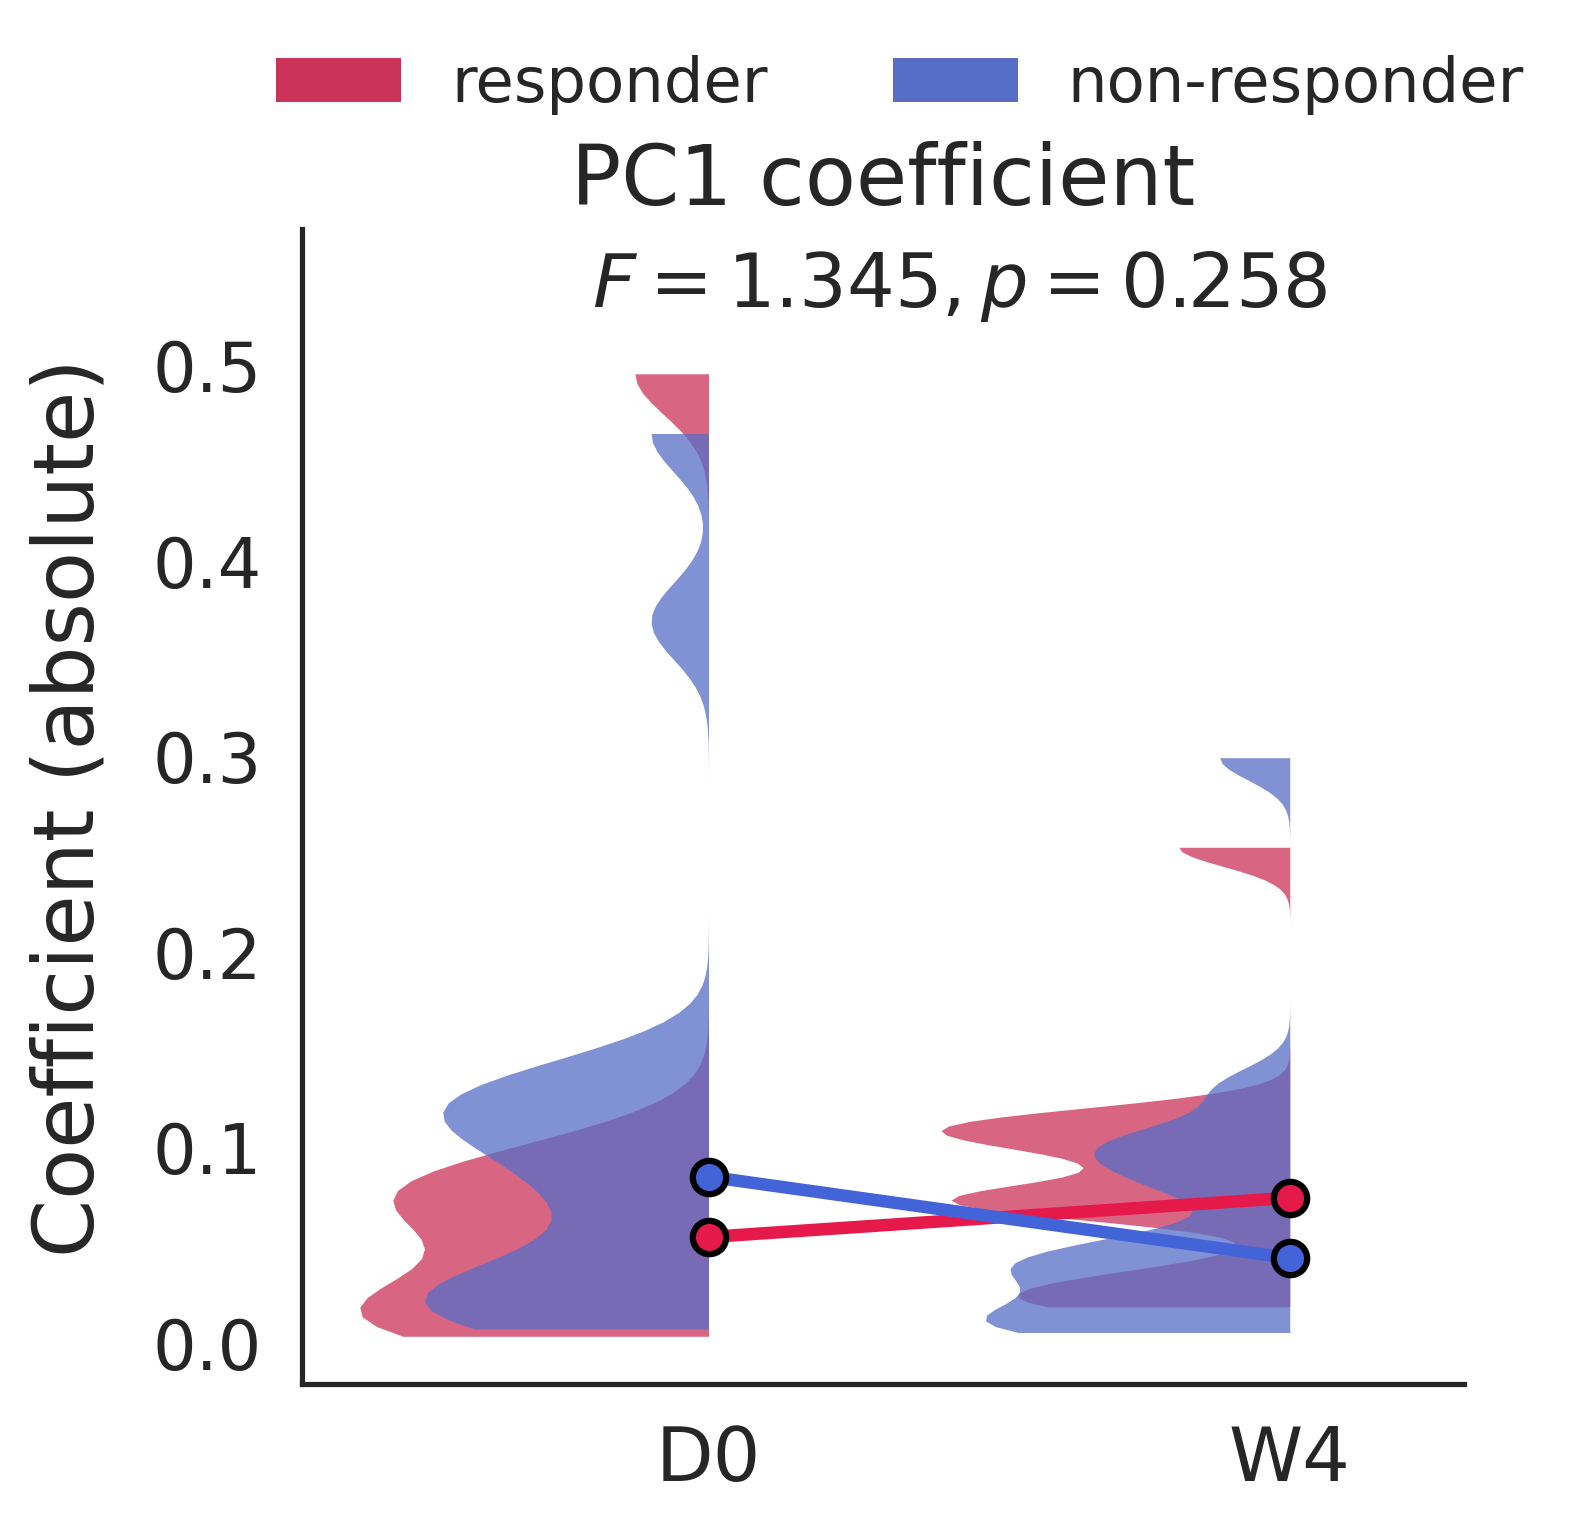

In [308]:
time_order = ['baseline',time2]
display_labels = ['D0',time2_display]
plot_cloud(c,'time','coef','responde',time_order,display_labels,
           title = "PC1 coefficient",text = r'$F=1.345 , p = 0.258$',y_label="Coefficient (absolute)")

In [309]:
from sklearn.decomposition import PCA
from sklearn.utils import resample

pca = PCA(n_components=1) 
scores_org = pca.fit_transform(data.T)
ld_org = pca.components_[0, :]


n_bootstraps = 1000
bootstrap_scores = np.zeros((data.shape[1], n_bootstraps))

for i in range(n_bootstraps):
    data_boot = resample(data, replace=True, n_samples=data.shape[0])
    
    score_boot = np.dot(ld_org,data_boot)
    
    bootstrap_scores[:, i] = score_boot

scores_boot = pd.DataFrame(bootstrap_scores.T,columns=roi_ls)
scores_boot = match_rsn(scores_boot)
x = np.percentile(scores_boot,2.5,axis=0)
y = np.percentile(scores_boot,97.5,axis=0)
z = match_rsn(pd.DataFrame(scores_org.T,columns=roi_ls)).values[0]
p_s = []
scores_boot = np.array(scores_boot)
for i in range(len(z)):
    x = scores_boot[:,i]
    if(z[i]>0):
        p = np.sum(x>z[i])/1000
    else:
        p = np.sum(x<z[i])/1000
    p_s.append(p)
p_s = BH_correct(p_s)

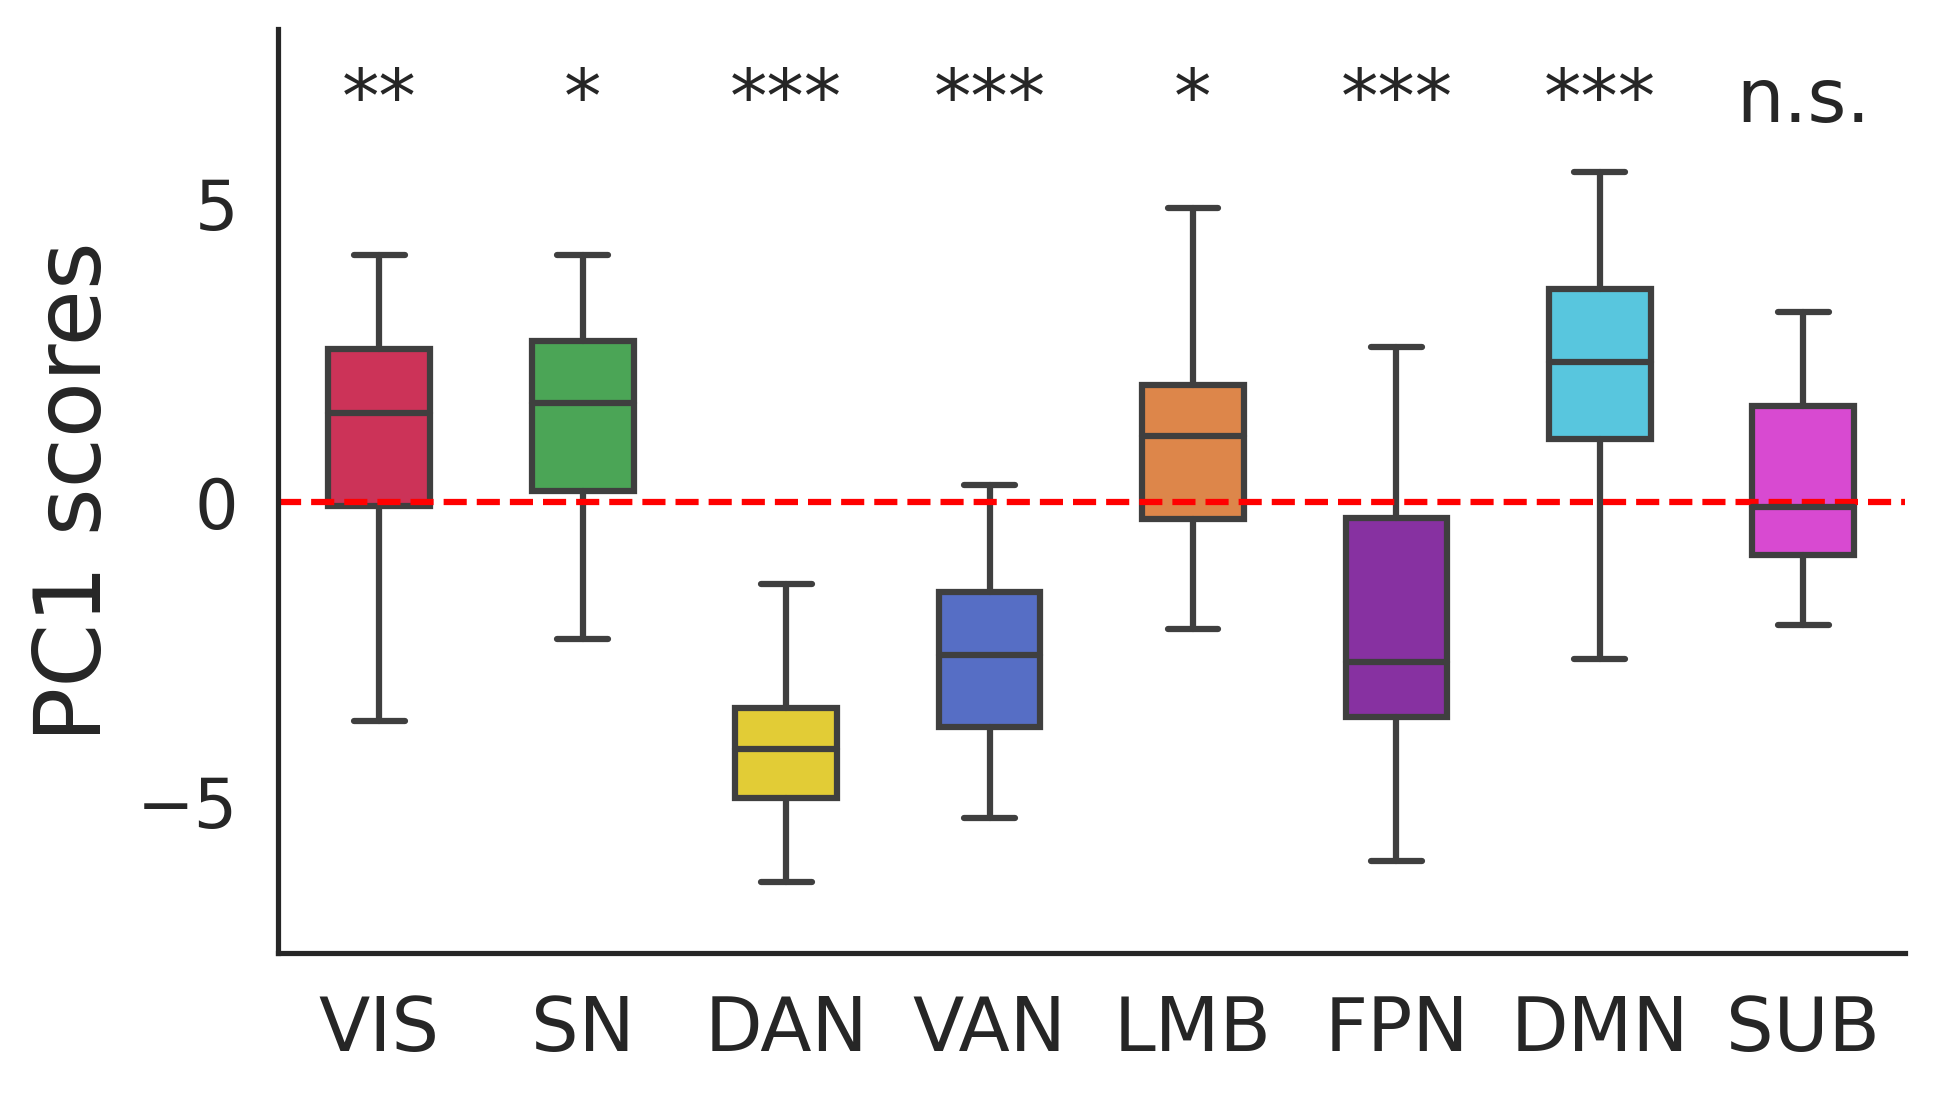

In [310]:
ICN_colors = ['#E6194B','#3CB44B','#FFE119','#4363D8','#F58231','#911EB4','#42D4F4','#F032E6']
df = pd.DataFrame(scores,columns = ['PC'+str(i) for i in range(1,scores.shape[1]+1)])
df['ICN'] = atlas['ICN'].tolist()+['Sub' for _ in range(19)]
df['PC1'] = -df['PC1']
plt.figure(figsize=(7,4),dpi=300)
sns.boxplot(data=df,x='ICN',y='PC1',palette=ICN_colors,width=.5,showfliers=False)
plt.xticks([i for i in range(len(ICNs))],ICN_ticks,fontsize=18);plt.xlabel('')
plt.axhline(0,color='red',linestyle='--')
plt.ylabel('PC1 scores',fontsize=22)
y_max = np.max(df['PC1']);y_min = np.min(df['PC1']);y_range=y_max-y_min
plt.ylim(y_min-0.1*y_range,y_max+0.2*y_range)
for i in range(len(p_s)):
    plt.text(i,y_max+0.1*y_range,p_star(p_s[i]),ha='center',va='center',fontsize=18)

pd.DataFrame(scores.reshape(-1)[:-19]).T.to_csv(f"/data/dy/TIS_MDD/NeuroMap/pca_pattern_{schaefer}.csv",index=False)

## Until W4

### PC1 coefficeint

In [286]:
time2 = '4weeks'
time2_label='4week'
time2_display = 'W4'
responder = get_responder(hamd,'HAMD_all',time2_label)
responder['responde'] = ['responder' if i else 'non-responder' for i in responder['responde']]

In [287]:
col_name = 'MADRS_all'
scale = hamd if col_name=='HAMD_all' else madrs
change = fun_scale_change(scale,col_name,time2_label)

In [288]:
ev_bold1 = get_event_bold('baseline')
ev_bold2 = get_event_bold(time2)
data = zscore(fun_concat(ev_bold1,ev_bold2),0)

pca = PCA(n_components=1)
scores = pca.fit_transform(data.T)
print(f"PC score大小：{scores.shape}")
coefficients = np.abs(pca.components_.T)
print(f"\nexplained_variance_ratio: {pca.explained_variance_ratio_}")

PC score大小：(119, 1)

explained_variance_ratio: [0.20327553]


In [289]:
a = pd.DataFrame(coefficients[:ev_bold2.shape[0]]-coefficients[ev_bold2.shape[0]:],index=ev_bold2.index,columns =['coef'])
a = pd.concat([a,responder,demo_info],axis=1).dropna(axis=0)
b = pd.concat([a,change],axis=1).dropna(axis=0)
b['scale'] = np.array(b['scale']).astype(np.float32)

partial_corr = pg.partial_corr(data=b,x='coef',y="scale",covar=["age", "sex_id"],method="pearson" )
rou,p = partial_corr.loc['pearson',['r','p-val']]
print(f"{rou:.2f},{p:.3f}")
if(p<0.5):
    y =np.array(b['scale']).astype(np.float64);x=np.array(b['coef']).astype(np.float64)
    ax=plt.figure(figsize=(7,4),
                  dpi=300
                 )
    sns.regplot(x=x, y=y,ci=95, 
                scatter_kws={"facecolors": "#262626","edgecolor": "#262626","s": 20,'alpha':0},
                line_kws={"color": c_line})
    plt.scatter(data=b[b['responde']=='responder'],x='coef',y='scale',color=res_colors[0],label='responder',s=30)
    plt.scatter(data=b[b['responde']!='responder'],x='coef',y='scale',color=res_colors[1],label='non-responder',s=30)
    x_max = np.max(x);x_min = np.min(x);x_range=x_max-x_min
    y_max = np.max(y);y_min = np.min(y);y_range=y_max-y_min
    
    y_text = y_min+y_range*.05;x_text = x_max-x_range*.2
    plt.text(x_text,y_text,f"r={rou:.3f}\np={p:.3f}",ha='left', va='bottom')
    
    plt.xlim(x_min-x_range*.1,x_max+x_range*.1)
    plt.ylim(y_min-y_range*.05,y_max+y_range*.05)
    
    plt.ylabel(f"Δ{col_name[:-4]} (D0→W4)",fontsize=17);plt.xlabel(f"Δ PC1 coefficient (D0→D5-post)",fontsize=17)
    plt.yticks(fontsize=15);plt.xticks(fontsize=15)
    legend = ax.legend(bbox_to_anchor=(0.1, 1.05), loc='upper left', frameon=False,handlelength=0.8,handletextpad=0.3,ncol=2)

b.to_csv('/data/dy/TIS_MDD/prediction/PC1_coefficients.csv')

-0.02,0.911
